# <span style="color:blue"> Esercitazione 7 - Simulazioni monte carlo in ensemble canonico, miglioramento del simulatore di dinamica molecolare </span>

## <span style="color:blue"> Indice</span>

- [Esercizio 7.1 - Aggiunta delle tail correction al simulatore](#Esercizio7.1)

- [Esercizio 7.2 - Studio dell'incertezza statistica in funzione della lunghezza dei blocchi](#Esercizio7.2)

- [Esercizio 7.3 - Calcolo della funzione di distribuzione radiale](#Esercizio7.3)
 
- [Esercizio 7.4 - Esecuzione di simulazioni MD e MC](#Esercizio7.4)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

## <span id="Esercizio7.1" style="color:blue">  Esercizio 7.1 - Aggiunta delle tail correction al simulatore </span>[^](#toc)

### Descrizione

Il calcolo — sia Monte Carlo (_MC_) che dinamica molecolare (_MD_) — implementato nel software C++ utilizzato nell'_Esercitazione 4_ calcola l'energia potenziale per particella $U/N$ e la pressione $P$ introducendo un'approssimazione dovuta al _cutoff_ del potenziale di interazione tra due particelle (per maggiori dettagli si veda l'_Esercizio 4.1_). In particolare, tutte le coppie di particelle con distanza maggiore di $r_{\mathrm{cutoff}}$ vengono considerate non interagenti.

L'approssimazione influisce direttamente sui valori di $U/N$ e $P$, poiché entrambe le grandezze contengono la somma dei contributi di interazione tra tutte le coppie del sistema. In maniera indiretta, però, l'approssimazione coinvolge anche il valore dell'energia cinetica $K/N$ calcolato nelle simulazioni MD, in quanto esse trattano il sistema secondo il modello dell'ensemble microcanonico, nel quale la quantità fissata (insieme a $V$ e $N$) è l'energia totale, $E$ o $E/N$. La conservazione di $E/N$ implica che un bias sul calcolo di $U/N$ si ripercuota in maniera simmetrica su $K/N$.

Per rendere la simulazione più realistica si introduce la cosiddetta _tail correction_ (correzione di coda), che stima il contributo del potenziale per $r>r_{\mathrm{cutoff}}$ assumendo che la funzione di distribuzione radiale sia $g(r)\simeq 1$ in tale regione.

Per il potenziale di Lennard-Jones si ottiene un contributo **additivo** per entrambe le grandezze:
- Correzione all’energia potenziale per particella:$$\frac{\langle U \rangle_{tail}}{N} = 8\pi\rho\sigma^3\epsilon\left[\frac{1}{9}\left( \frac{\sigma}{r_{\mathrm{cutoff}}} \right)^9 -\frac{1}{3}\left( \frac{\sigma}{r_{\mathrm{cutoff}}}\right) ^3\right]$$
  che in coordinate ridotte diventa $$\frac{\langle U^\star \rangle_{tail}}{N} = 8\pi\rho^\star\left(\frac{1}{9r_{\mathrm{cutoff}}^{\star 9}}-\frac{1}{3r_{\mathrm{cutoff}}^{\star 3}}\right)$$
- Correzione alla pressione: $$\langle P \rangle_{tail}=32\pi\rho^2\sigma^3\epsilon\left[\frac{1}{9}\left( \frac{\sigma}{r_{\mathrm{cutoff}}}\right)^9-\frac{1}{6}\left(\frac{\sigma}{r_{\mathrm{cutoff}}}\right)^3\right]$$
  ovvero, in coordinate ridotte: $$\langle P \rangle_{tail}=32\pi\rho^{\star 2}\left(\frac{1}{9 r_{\mathrm{cutoff}}^{\star 9}}-\frac{1}{6 r_{\mathrm{cutoff}}^{\star 3}}\right)$$

_Note_:
- la correzione è stata applicata sia per calcoli MC che per calcoli MD.
- Essendo $E/N=U/N+K/N$, la correzione all'energia potenziale è stata applicata anche all'energia totale

### Calcolo e risultati

Di seguito si mostrano i risultati del calcolo di dinamica molecolare di $U/N$ e $P$ per la fase liquida con $N=108$ particelle e 
- Densità: $\rho^\star = 0.8$
- Temperatura: $T^\star = 1.1$
- Raggio di cutoff: $r_c = 2.5$

Questa simulazione è la medesima svolta nell'_Esercizio 4.2_:
- La temperatura di equilibrio di $T^\star = 1.1$ è stata ottenuta partendo con $T^*=1.98$.
- Sono stati considerati i valori ottenuti dopo i $6000$ step necessari all'equilibrazione (è stata utilizzata l'opzione `restart` nel codice), dove è stata posta $T^\star=1.1$.
- È stata calcolata la media progressiva, con relativa incertezza, per $N=50$ blocchi da $2000$ valori ciascuno.

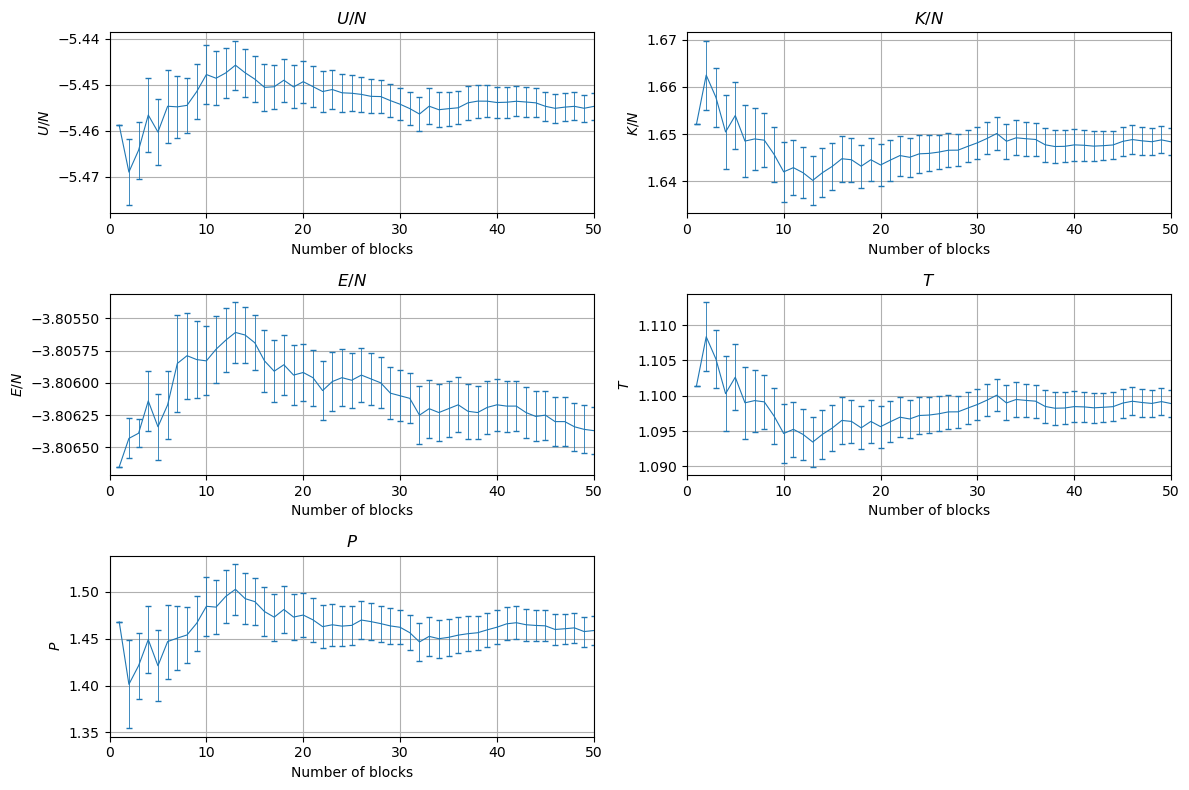

In [22]:
base_path="../Es07_01/Output/"
# Load progressive averages and errors
Block,U_l,Uerr_l=np.loadtxt(base_path+"output_epot.dat",usecols=(0,2,3),unpack=True)    # The output files are renamed after program excecution 
_,K_l,Kerr_l=np.loadtxt(base_path+"output_ekin.dat",usecols=(0,2,3),unpack=True)
_,E_l,Eerr_l=np.loadtxt(base_path+"output_etot.dat",usecols=(0,2,3),unpack=True)
_,T_l,Terr_l=np.loadtxt(base_path+"output_temp.dat",usecols=(0,2,3),unpack=True)
_,P_l,Perr_l=np.loadtxt(base_path+"output_pres.dat",usecols=(0,2,3),unpack=True)

fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
data=[U_l,K_l,E_l,T_l,P_l]
err=[Uerr_l,Kerr_l,Eerr_l,Terr_l,Perr_l]
titles=['$U/N$','$K/N$','$E/N$','$T$','$P$']
ylabs=[r'$U/N$',r'$K/N$',r'$E/N$',r'$T$',r'$P$']
for i in range(5):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
axs[5].axis('off')
plt.tight_layout()
plt.show()

In [24]:
kB=1.380649e-23
eps=120*kB
sigma=0.34e-09
q=1.602177e-19

print(f"Risultati:")
print(f"Potential energy per particle: {U_l[-1]:.4f}   ±{Uerr_l[-1]:.4f}  ----->  ( {U_l[-1]*eps/q*1000:.3f}  ±{Uerr_l[-1]*eps/q*1000:.3f}  ) meV")
print(f"Kinetic energy per particle:    {K_l[-1]:.4f}   ±{Kerr_l[-1]:.4f}  ----->  (  {K_l[-1]*eps/q*1000:.3f}  ±{Kerr_l[-1]*eps/q*1000:.3f}  ) meV")
print(f"Total energy per particle:     {E_l[-1]:.4f}   ±{Eerr_l[-1]:.4f}  ----->  ( {E_l[-1]*eps/q*1000:.4f} ±{Eerr_l[-1]*eps/q*1000:.4f} ) meV")
print(f"Temperature:                    {T_l[-1]:.4f}   ±{Terr_l[-1]:.4f}  ----->  ( {T_l[-1]*eps/kB:.2f}   ±{Terr_l[-1]*eps/kB:.2f}   ) K")
print(f"Pressure:                       {P_l[-1]:.3f}    ±{Perr_l[-1]:.3f}   ----->  ( {P_l[-1]*eps/(sigma)**3*10**(-5):.1f}    ±{Perr_l[-1]*eps/(sigma)**3*10**(-5):.1f}    ) bar")

Risultati:
Potential energy per particle: -5.4547   ±0.0029  ----->  ( -56.406  ±0.030  ) meV
Kinetic energy per particle:    1.6483   ±0.0029  ----->  (  17.045  ±0.030  ) meV
Total energy per particle:     -3.8064   ±0.0002  ----->  ( -39.3609 ±0.0019 ) meV
Temperature:                    1.0989   ±0.0019  ----->  ( 131.87   ±0.23   ) K
Pressure:                       1.459    ±0.016   ----->  ( 614.9    ±6.6    ) bar


Confrontando i risultati con quelli ottenuti nella precedente simulazione, si osserva che
- i valori di $K/N$ e $T/N$ non sono cambiati in maniera significativa, come atteso;
- i valori di $U/N$ e $P$ sono cambiati in modo significativo: la pressione è diminuita di $2.137-1.459=0.678$, mentre l'energia potenziale per particella ha visto una riduzione di $-5.0231-(-5.4547)=0.4316$. Apparentemente, l'approssimazione introdotta dal cutoff del potenziale aveva l'effetto di sottostimare (in valore assoluto) la somma dei termini di interazione tra coppie di particelle;
- il valore di $E/N$ è diminuito di $-3.3771-(-3.8064)=0.4293$, in linea con la riduzione di $U/P$.

## <span id="Esercizio7.2" style="color:blue">  Esercizio 7.2 - Studio dell'incertezza statistica in funzione della lunghezza dei blocchi </span>[^](#toc)

In questo esercizio è stato condotto uno studio sul legame tra l'incertezza statistica del calcolo Monte Carlo e la lunghezza dei blocchi utilizzati nella blocking average. Per l'analisi sono state considerate solo le serie di dati ottenute dal calcolo di $U/N$.

### i. Esecuzione di $M$ step Monte Carlo

Sono stati eseguiti $M=50000$ step Monte Carlo (di fatto, $M$ blocchi di lunghezza $1$) di queste condizioni:
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$, $r_c = 2.2$
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$, $r_c = 2.5$
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$, $r_c = 5.0$

Queste sono le stesse condizioni simulate nell'_Esercizio 4.2_, ma questa volta sono simulate con la tecnica MC.
- non è stato necessario preparare le simulazioni a temperature superiori a quelle desiderate, in quando il codice si basa sul modello dell'ensemble canonico: la $T$ è fissata come parametro;
- è comunque necessario attendere l'equilibrazione dell'algoritmo di Metropolis, che sta alla base della simulazione Monte Carlo
- in ciascun caso, è stato scelto un valore del passo proposto dall'algoritmo tale che l'accettazione fosse prossima al $50$%.

#### Stato solido

- È stato scelto un passo ampio $0.11$. L'acceptance rate ottenuto è del $51$%.
- Per l'equilibrazione, sono stati simulati $5000$ step. Al termine di essi, $U/N$ ha mostrato fluttuazioni molto minori dell'$1$%, come mostrato di seguito:

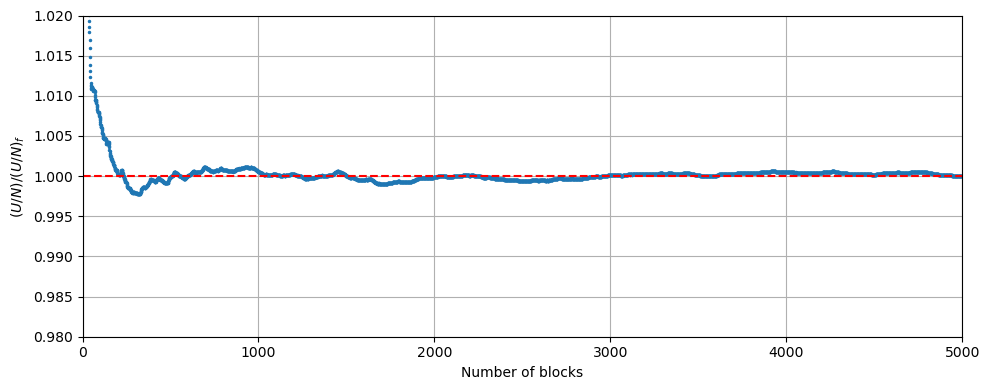

In [60]:
# Load block averages (columns: block, block_mean)
base_path="../Es07_02/Output/"
Block,U=np.loadtxt(base_path+"output_epot_solid_eq.dat",usecols=(0,2), unpack=True)

# Normalize to final value
U=U/U[-1]
plt.figure(figsize=(10,4))
plt.plot(Block,U,'.',markersize=3)
plt.axhline(1.0,color='r',linestyle='--')
plt.xlim(0,Block[-1])
plt.ylim(0.98,1.02)
plt.xlabel('Number of blocks')
plt.ylabel(r'$(U/N)/(U/N)_{f}$')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Stato liquido

- È stato scelto un passo ampio $0.2$. L'acceptance rate ottenuto è del $51$%.
- Per l'equilibrazione, sono stati simulati $5000$ step. Al termine di essi, $U/N$ ha mostrato fluttuazioni molto minori dell'$1$%, come mostrato di seguito

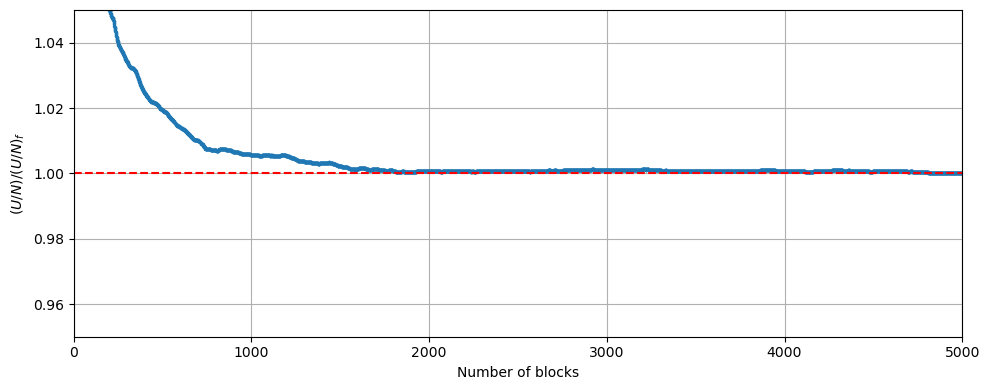

In [81]:
# Load block averages (columns: block, block_mean)
Block,U=np.loadtxt(base_path+"output_epot_liquid_eq.dat",usecols=(0,2), unpack=True)

# Normalize to final value
U=U/U[-1]
plt.figure(figsize=(10,4))
plt.plot(Block,U,'.',markersize=3)
plt.axhline(1.0,color='r',linestyle='--')
plt.xlim(0,Block[-1])
plt.ylim(0.95,1.05)
plt.xlabel('Number of blocks')
plt.ylabel(r'$(U/N)/(U/N)_{f}$')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Stato gassoso

- È stato scelto un passo ampio $6.0$ (la cella della simulazione ha lato $12.92$). L'acceptance rate ottenuto è del $62$%.
- Per l'equilibrazione, sono stati simulati $5000$ step. Al termine di essi, $U/N$ ha mostrato fluttuazioni minori dell'$1$%, sebbene maggiori di quelle dei due casi precedenti:

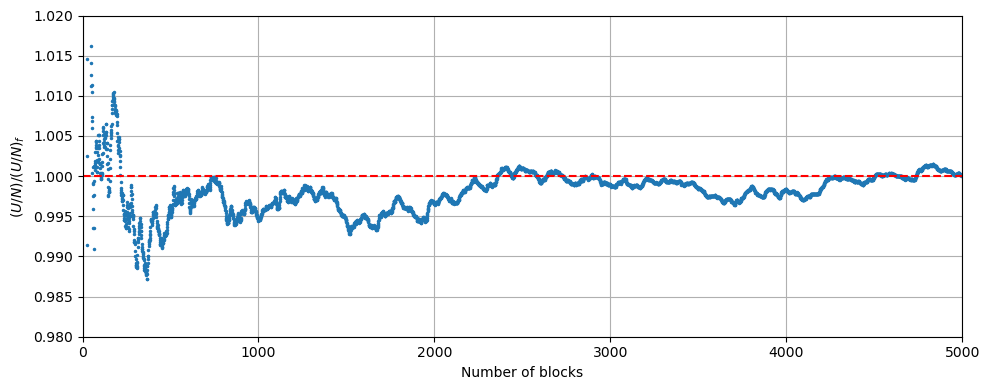

In [98]:
# Load block averages (columns: block, block_mean)
Block,U=np.loadtxt(base_path+"output_epot_gas_eq.dat",usecols=(0,2), unpack=True)

# Normalize to final value
U=U/U[-1]
plt.figure(figsize=(10,4))
plt.plot(Block,U,'.',markersize=3)
plt.axhline(1.0,color='r',linestyle='--')
plt.xlim(0,Block[-1])
plt.ylim(0.98,1.02)
plt.xlabel('Number of blocks')
plt.ylabel(r'$(U/N)/(U/N)_{f}$')
plt.grid(True)
plt.tight_layout()
plt.show()

### ii. Calcolo dell'autocorrelazione della serie di dati

Per ciascuna delle tre serie di dati relative a $U/N$ è stata calcolata la funzione di autocorrelazione normalizzata:
$$
C(\tau)=\frac{\left\langle \left(\frac{U}{N}(t)-\left\langle \frac{U}{N}\right\rangle\right)
\left(\frac{U}{N}(t+\tau)-\left\langle \frac{U}{N}\right\rangle\right)\right\rangle}
{\left\langle \left(\frac{U}{N}(t)-\left\langle \frac{U}{N}\right\rangle\right)^2\right\rangle}$$

dove $t$ rappresenta il lag temporale espresso in numero di blocchi.

L'autocorrelazione è stata calcolata mediante la funzione `np.correlate`, sottraendo preliminarmente il valor medio alla serie di dati.

L'obiettivo di questa analisi è stimare il tempo caratteristico di correlazione della simulazione, ossia il numero di step oltre il quale due misure di $U/N$ possono essere considerate statisticamente indipendenti.

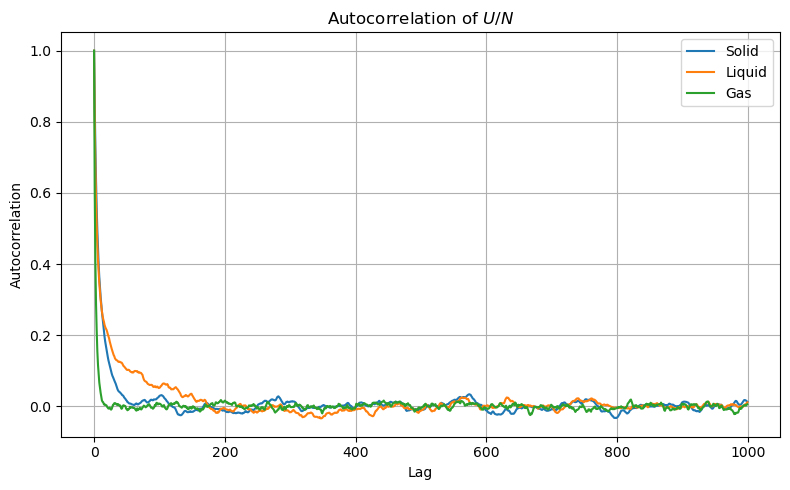

In [122]:
# Solid
_, U=np.loadtxt(base_path+"output_epot_solid.dat",usecols=(0,1),unpack=True)
U=U-np.mean(U)
corr_s=np.correlate(U,U,mode='full')
corr_s=corr_s[corr_s.size//2:]
corr_s=corr_s/corr_s[0]
# Liquid
_, U=np.loadtxt(base_path+"output_epot_liquid.dat",usecols=(0,1),unpack=True)
U=U-np.mean(U)
corr_l=np.correlate(U,U,mode='full')
corr_l=corr_l[corr_l.size//2:]
corr_l=corr_l/corr_l[0]
# Gas
_, U=np.loadtxt(base_path+"output_epot_gas.dat",usecols=(0,1), unpack=True)
U=U-np.mean(U)
corr_g=np.correlate(U,U,mode='full')
corr_g=corr_g[corr_g.size//2:]
corr_g=corr_g/corr_g[0]

# plot
max_lag=1000
plt.figure(figsize=(8,5))
plt.plot(corr_s[:max_lag],label="Solid")
plt.plot(corr_l[:max_lag],label="Liquid")
plt.plot(corr_g[:max_lag],label="Gas")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of $U/N$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Si osserva che la fase liquida presenta il tempo caratteristico di correlazione maggiore, seguita dalla fase solida e infine dalla fase gassosa. In particolare, per un numero di step Monte Carlo $\tau \gtrsim 100$ la funzione $C(\tau)$ per gas e solido può considerarsi decaduta (entro le fluttuazioni statistiche), mentre per il liquido sono necessari $\tau>200$ step.

Nella fase liquida, per la simulazione Monte Carlo, configurazioni successive risultano maggiormente correlate rispetto agli altri due casi.

### iii. Calcolo della lunghezza necessaria dei blocchi

Per determinare la lunghezza minima necessaria dei blocchi, in modo da ottenere una serie di block average considerabili statisticamente indipendenti tra loro — e quindi applicare correttamente il teorema del limite centrale nella stima dell'incertezza — si possono calcolare diverse medie a blocchi, ciascuna con lunghezza $L$ diversa.

Si ha che:
- se $L$ non è significativamente maggiore del tempo caratteristico di correlazione, le block average non sono statisticamente indipendenti (le ipotesi del CLT non sono soddisfatte) e l'incertezza progressiva non segue correttamente l’andamento $\sim 1/\sqrt{N_{\mathrm{blocks}}}$ al crescere del numero di blocchi $N_{\mathrm{blocks}}$;
- se $L$ è sufficientemente grande, le block average possono essere considerate indipendenti, le ipotesi del CLT risultano soddisfatte e l'incertezza progressiva del calcolo segue l’andamento regolare $\sim 1/\sqrt{N_{\mathrm{blocks}}}$; il valore finale può quindi essere interpretato come stima affidabile dell'incertezza statistica.

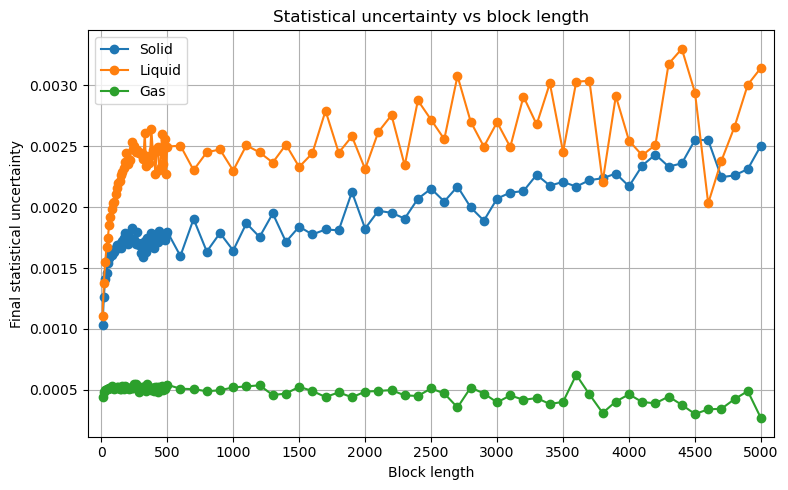

In [182]:
L_values=np.concatenate((np.arange(10,491,10),np.arange(500, 5001, 100)))
def BlockAnalysis(U,L):
    M=len(U)
    n_blocks=M//L
    U=U[:n_blocks*L]
    blocks=U.reshape(n_blocks,L)
    block_means=np.mean(blocks,axis=1)
    MeanProg=np.cumsum(block_means)/np.arange(1,n_blocks+1)
    Mean2Prog=np.cumsum(block_means**2)/np.arange(1,n_blocks+1)
    DevStProg=np.sqrt((Mean2Prog-MeanProg**2)/np.arange(1,n_blocks+1))
    return MeanProg,DevStProg
def compute_sigma_final(filename):
    _,U=np.loadtxt(base_path+filename,usecols=(0,1),unpack=True)
    sigma=[]
    for L in L_values:
        MeanProg,DevStProg=BlockAnalysis(U,L)
        sigma.append(DevStProg[-1])
    return np.array(sigma)

sigma_s=compute_sigma_final("output_epot_solid.dat")
sigma_l=compute_sigma_final("output_epot_liquid.dat")
sigma_g=compute_sigma_final("output_epot_gas.dat")

# Plot
plt.figure(figsize=(8,5))
plt.plot(L_values,sigma_s,'o-',label="Solid")
plt.plot(L_values,sigma_l,'o-',label="Liquid")
plt.plot(L_values,sigma_g,'o-',label="Gas")
plt.xlabel("Block length")
plt.ylabel("Final statistical uncertainty")
plt.title("Statistical uncertainty vs block length")
plt.xticks(np.arange(0,5001,500))
plt.xlim(-100,5100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Si osserva che la crescita iniziale dell’incertezza viene progressivamente smorzata in tutti e tre i casi. In particolare:
- per la fase gassosa la curva risulta sostanzialmente saturata già per $L \gtrsim 50$;
- per la fase solida la saturazione si osserva per $L \gtrsim 200$;
- per la fase liquida è necessario spingersi fino a $L \gtrsim 400$.

(Per visualizzare meglio tale comportamento si consiglia di restringere l’intervallo del grafico mediante `plt.xlim()`.)

La saturazione della curva ha un significato statistico preciso.
- Per blocchi troppo piccoli ($L$ minore del tempo caratteristico di correlazione $\tau$), le block average non sono indipendenti e la formula dell’incertezza basata sul teorema del limite centrale,
$$
\sigma_{avg} \sim \frac{\sigma}{\sqrt{N_{\mathrm{blocks}}}},
$$
sottostima significativamente l’incertezza reale del calcolo.
- Quando invece $L \gg \tau$, le block average possono considerarsi indipendenti, le ipotesi del CLT risultano soddisfatte e l’incertezza si stabilizza attorno al valore corretto. La lunghezza del blocco deve quindi essere scelta nella regione in cui la curva è satura e stabile.

Dai grafici si può concludere che:
- per il gas è sufficiente $L \gtrsim 100$;
- per il solido è opportuno scegliere $L \gtrsim 300$–$400$;
- per il liquido sono necessari blocchi più lunghi, dell’ordine di $L \sim 900$–$1000$.

Infine, si osserva che per solido e liquido, al crescere di $L$, l’incertezza tende a oscillare maggiormente. Ciò è dovuto al fatto che, fissato il numero totale di dati $M$, aumentando $L$ il numero di blocchi diminuisce, e quindi la stima stessa dell’incertezza diventa più rumorosa.   Nel caso del gas tale effetto è meno evidente poiché il tempo di correlazione è talmente breve che il valore medio sul blocco risulta molto più stabilizzato: le fluttuazioni relative risultano quindi meno marcate.

## <span id="Esercizio7.3" style="color:blue">  Esercizio 7.3 - Calcolo della funzione di distribuzione radiale </span>[^](#toc)

### Descrizione

In questo esercizio è stato aggiunto al codice un metodo per il calcolo della funzione di distribuzione radiale del sistema termodinamico, che in un sistema isotropo è esprimibile come $g^{(2)}(r)$, dove $r$ è la distanza radiale tra una coppia qualsiasi di particelle.

Essa è una distribuzione che fornisce la probabilità di trovare due particelle del sistema a una distanza reciproca compresa nell’intervallo $[r,r+dr]$, normalizzata rispetto alla medesima probabilità per un sistema con la stessa densità ma distribuito in modo completamente casuale (gas ideale).

La formula base utilizzata per il calcolo di $g(r)$ è
$$g(r)=\frac{1}{\rho N \Delta V(r)}\left\langle \sum_{i\neq j}^N\delta(r-r_{ij}) \right\rangle .$$

dove:
- la media è una media di ensemble, calcolata su un numero elevato di configurazioni generate con l'algoritmo MD o MC;
- $r_{ij}$ è la distanza tra la coppia di particelle $i$-$j$;
- $\rho$ è la densità numerica globale del sistema e $N$ il numero totale di particelle nella cella.

Essendo $g(r)$ una distribuzione, per misurarla è necessario, ad ogni step della simulazione, costruire un istogramma delle distanze reciproche:
- si è scelto di misurarla nel range $[0,L_{box}/2]$, con $L_{box}$ lato della cella di simulazione;
- tale intervallo è stato suddiviso in $N_{\mathrm{bins}}$ bin. In ciascun bin si conta il numero di coppie di particelle la cui distanza cade nel range definito dal bin stesso. In questo modo si ottiene una realizzazione discreta della quantità
$$\tilde{g}(r)=\sum_{i\neq j}^N\delta(r-r_{ij})$$
in un dato istante;
- il valore ottenuto viene normalizzato per il numero di particelle $N$ e per il volume della crosta sferica delimitata dagli estremi del bin. Se un bin ha estremi $r_{\mathrm{lower}}$ e $r_{\mathrm{upper}}$, il volume della crosta è
$$
\Delta V(r_{\mathrm{lower}})=\frac{4\pi}{3}\left[r_{\mathrm{upper}}^3-r_{\mathrm{lower}}^3\right];
$$
quest'ultima normalizzazione consiste nel dividere per la dimensione del bin;
- infine si divide per la densità numerica globale $\rho$, che rappresenta la densità di riferimento di un sistema completamente casuale.

I valori ottenuti ad ogni step vengono mediati con la tecnica della media a blocchi.  
(_Nota_: viene eseguita una blocking average per ciascun bin dell’istogramma, in quanto ogni bin costituisce a tutti gli effetti un’osservabile del sistema, al pari di $T$ o $U/N$.)

Infine, l’implementazione non esegue la doppia somma ripetuta sulle coppie di particelle, ma una doppia somma non ripetuta ($i<j$). Poiché la coppia $i$-$j$ è equivalente alla coppia $j$-$i$, ogni coppia viene considerata una sola volta per efficienza computazionale. Per mantenere la corretta normalizzazione, ogni volta che una distanza $r$ cade in un bin, il conteggio del bin viene incrementato di $2$ anziché di $1$.

### Parametri del calcolo

La distribuzione $g(r)$ è stata ottenuta impostando $N_{\mathrm{bins}}=100$. 

Poiché l’intervallo radiale considerato è $[0,\,L_{box}/2]$, la lunghezza di ciascun bin è
$$\Delta r =r_{\mathrm{upper}} - r_{\mathrm{lower}}= \frac{L_{box}/2}{N_{\mathrm{bins}}}= \frac{L_{box}}{200}$$

## <span id="Esercizio7.4" style="color:blue">  Esercizio 7.4 - Esecuzione di simulazioni MD e MC </span>[^](#toc)

In questo esercizio è stato usato il simulatore "completo", migliorato durante le _Esercitazioni 4_ e _7_, per simulare simulazioni Monte Carlo NVT (ensemble canonico) analoghe a quelle svolte nell'_Esercizio 4.2_: è stato considerato un sistema di $N=108$ particelle di argon, con interazioni modellizzate dal potenziale di Lennard-Jones ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu), nelle tre condizioni già viste:
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$, $r_c=2.2$
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$, $r_c = 2.5$
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$, $r_c = 5.0$

_Nota_: i risultati della simulazione si trovano nella cartella dell'_Esercizio 7.3_.

### i. Fase solida

Seguendo ciò che si è appreso negli esercizi precedenti:
- è stato scelto un passo ampio $0.11$. L'acceptance rate ottenuto è del $51$%;
- per l'equilibrazione, sono stati simulati $5000$ step (_Nota_: i dati non sono stati salvati);
- la simulazione è stata condotta con $50$ blocchi da $L=4000$ step ciascuno.

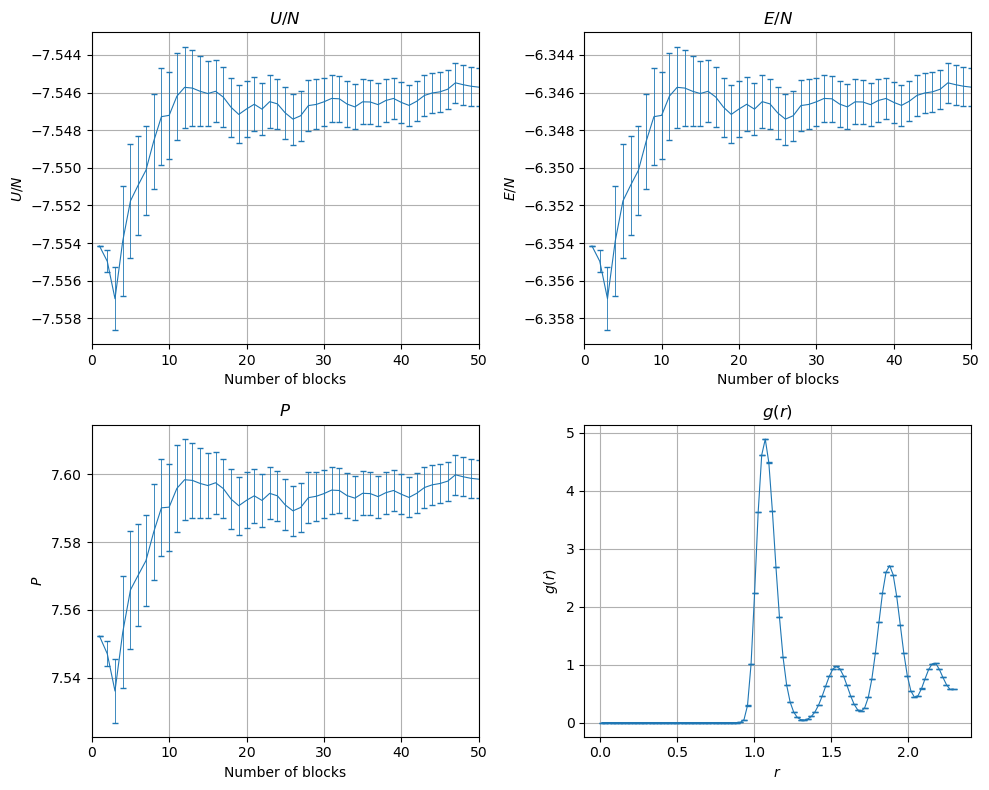

In [291]:
base_path = "../Es07_03/Output/"
# Load progressive averages (solid phase)
Block,U_s,Uerr_s=np.loadtxt(base_path+"output_epot_solid.dat",usecols=(0,2,3),unpack=True)
_,E_s,Eerr_s    =np.loadtxt(base_path+"output_etot_solid.dat",usecols=(0,2,3), unpack=True)
_,P_s,Perr_s    =np.loadtxt(base_path+"output_pres_solid.dat",usecols=(0,2,3), unpack=True)
# Load final g(r)
r_s,g_s,gerr_s  =np.loadtxt(base_path+"output_gfinal_solid.dat",unpack=True)

fig,axs=plt.subplots(2,2,figsize=(10,8))
axs=axs.flatten()
data  =[U_s,E_s,P_s]
err   =[Uerr_s,Eerr_s,Perr_s]
titles=['$U/N$','$E/N$','$P$']
ylabs =[r'$U/N$',r'$E/N$',r'$P$']
for i in range(3):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
# g(r)
axs[3].errorbar(r_s,g_s,yerr=gerr_s,fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
axs[3].set_title('$g(r)$')
axs[3].set_xlabel(r'$r$')
axs[3].set_ylabel(r'$g(r)$')
axs[3].grid(True)

plt.tight_layout()
plt.show()

### ii. Fase liquida

Seguendo ciò che si è appreso negli esercizi precedenti:
- è stato scelto un passo ampio $0.2$. L'acceptance rate ottenuto è del $51$%;
- per l'equilibrazione, sono stati simulati $5000$ step (_Nota_: i dati non sono stati salvati);
- la simulazione è stata condotta con $50$ blocchi da $L=4000$ step ciascuno.

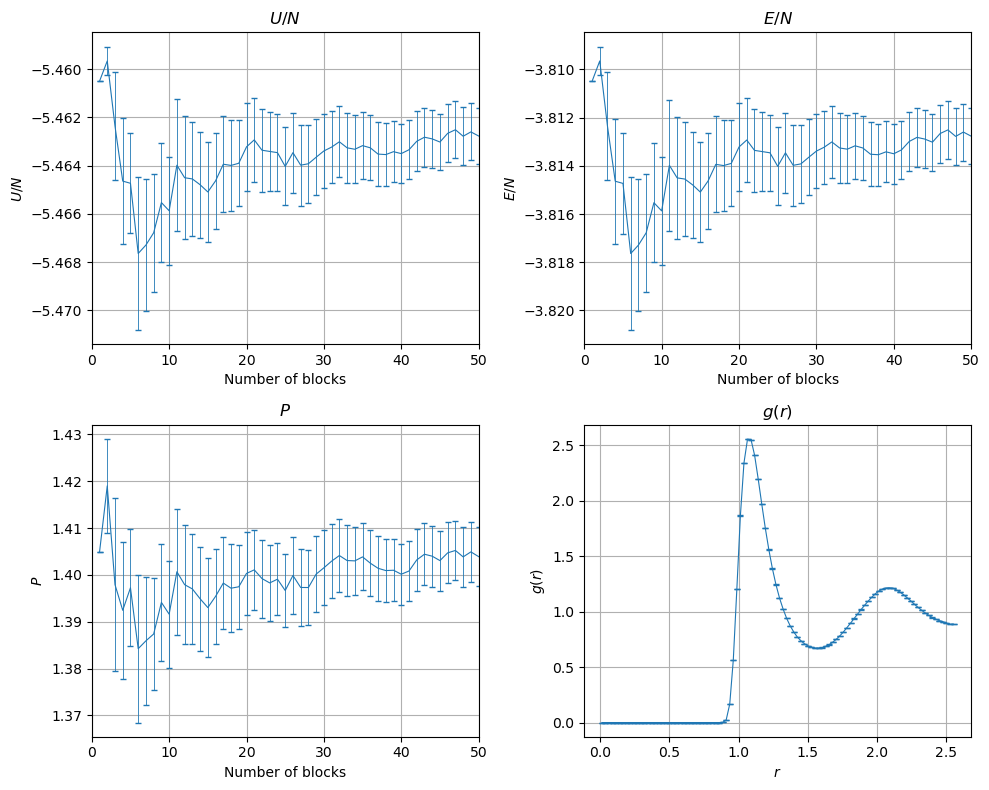

In [293]:
# Load progressive averages (liquid phase)
Block,U_l,Uerr_l=np.loadtxt(base_path+"output_epot_liquid.dat",usecols=(0,2,3),unpack=True)
_,E_l,Eerr_l    =np.loadtxt(base_path+"output_etot_liquid.dat",usecols=(0,2,3), unpack=True)
_,P_l,Perr_l    =np.loadtxt(base_path+"output_pres_liquid.dat",usecols=(0,2,3), unpack=True)
# Load final g(r)
r_l,g_l,gerr_l  =np.loadtxt(base_path+"output_gfinal_liquid.dat",unpack=True)

fig,axs=plt.subplots(2,2,figsize=(10,8))
axs=axs.flatten()
data  =[U_l,E_l,P_l]
err   =[Uerr_l,Eerr_l,Perr_l]
titles=['$U/N$','$E/N$','$P$']
ylabs =[r'$U/N$',r'$E/N$',r'$P$']
for i in range(3):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
# g(r)
axs[3].errorbar(r_l,g_l,yerr=gerr_l,fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
axs[3].set_title('$g(r)$')
axs[3].set_xlabel(r'$r$')
axs[3].set_ylabel(r'$g(r)$')
axs[3].grid(True)

plt.tight_layout()
plt.show()

### iii. Fase gassosa

Seguendo ciò che si è appreso negli esercizi precedenti:
- è stato scelto un passo ampio $6.0$. L'acceptance rate ottenuto è del $62$%;
- per l'equilibrazione, sono stati simulati $5000$ step (_Nota_: i dati non sono stati salvati);
- la simulazione è stata condotta con $50$ blocchi da $L=4000$ step ciascuno.

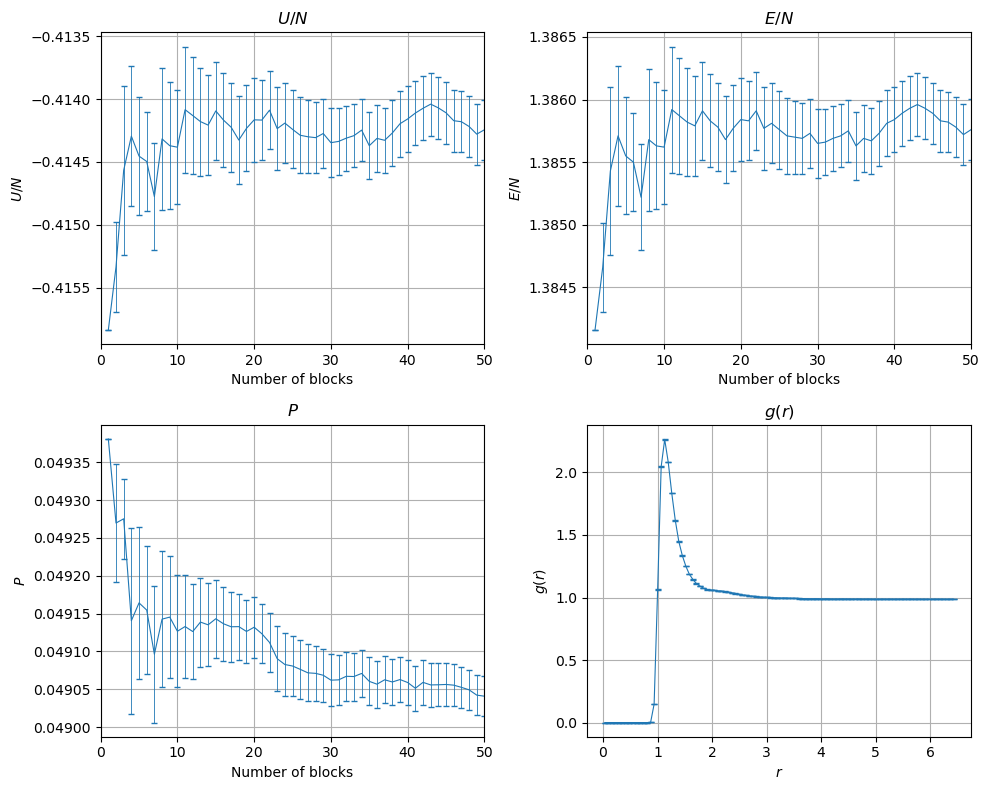

In [306]:
# Load progressive averages (gaseous phase)
Block,U_g,Uerr_g=np.loadtxt(base_path+"output_epot_gas.dat",usecols=(0,2,3),unpack=True)
_,E_g,Eerr_g    =np.loadtxt(base_path+"output_etot_gas.dat",usecols=(0,2,3), unpack=True)
_,P_g,Perr_g    =np.loadtxt(base_path+"output_pres_gas.dat",usecols=(0,2,3), unpack=True)
# Load final g(r)
r_g,g_g,gerr_g  =np.loadtxt(base_path+"output_gfinal_gas.dat",unpack=True)

fig,axs=plt.subplots(2,2,figsize=(10,8))
axs=axs.flatten()
data  =[U_g,E_g,P_g]
err   =[Uerr_g,Eerr_g,Perr_g]
titles=['$U/N$','$E/N$','$P$']
ylabs =[r'$U/N$',r'$E/N$',r'$P$']
for i in range(3):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
# g(r)
axs[3].errorbar(r_g,g_g,yerr=gerr_g,fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
axs[3].set_title('$g(r)$')
axs[3].set_xlabel(r'$r$')
axs[3].set_ylabel(r'$g(r)$')
axs[3].grid(True)

plt.tight_layout()
plt.show()

### iv. Confronto

In tutti i casi, per ogni grandezza calcolata, il comportamento di valor medio progressivo e incertezza progressiva sono stati in accordo con quelli attesi, e la forma di $g(r)$ è in accordo con quella attesa.

Di seguito si riportano i risultati delle simulazioni
- in unità ridotte
- in unità del SI. Le conversioni effettuate sono le seguenti:
    - $U=\epsilon U^\star$, $E=\epsilon E^\star$
    - $P=\frac{\epsilon}{\sigma^3}P^\star$

In [302]:
kB=1.380649e-23
eps=120*kB
sigma=0.34e-09
q=1.602177e-19

print(f"----- Solid -----")
print(f"Potential energy per particle: {U_s[-1]:.5f}  ±{Uerr_s[-1]:.5f} ----->  ( {U_s[-1]*eps/q*1000:.4f} ±{Uerr_s[-1]*eps/q*1000:.4f} ) meV")
print(f"Total energy per particle:     {E_s[-1]:.5f}  ±{Eerr_s[-1]:.5f} ----->  ( {E_s[-1]*eps/q*1000:.5f}±{Eerr_s[-1]*eps/q*1000:.5f}) meV")
print(f"Pressure:                       {P_s[-1]:.4f}   ±{Perr_s[-1]:.4f}  ----->  ({P_s[-1]*eps/(sigma)**3*10**(-5):.1f}    ±{Perr_s[-1]*eps/(sigma)**3*10**(-5):.1f}    ) bar")
print(f"----- Liquid ----")
print(f"Potential energy per particle: {U_l[-1]:.4f}   ±{Uerr_l[-1]:.4f}  ----->  ( {U_l[-1]*eps/q*1000:.3f}  ±{Uerr_l[-1]*eps/q*1000:.3f}  ) meV")
print(f"Total energy per particle:     {E_l[-1]:.4f}   ±{Eerr_l[-1]:.4f}  ----->  ( {E_l[-1]*eps/q*1000:.4f} ±{Eerr_l[-1]*eps/q*1000:.4f} ) meV")
print(f"Pressure:                       {P_l[-1]:.3f}    ±{Perr_l[-1]:.3f}   ----->  ( {P_l[-1]*eps/(sigma)**3*10**(-5):.1f}    ±{Perr_l[-1]*eps/(sigma)**3*10**(-5):.1f}    ) bar")
print(f"----- Gas ------")
print(f"Potential energy per particle: {U_g[-1]:.4f}   ±{Uerr_g[-1]:.4f}  ----->  (  {U_g[-1]*eps/q*1000:.3f}  ±{Uerr_g[-1]*eps/q*1000:.3f}  ) meV")
print(f"Total energy per particle:      {E_g[-1]:.6f} ±{Eerr_g[-1]:.6f}----->  (  {E_g[-1]*eps/q*1000:.5f}±{Eerr_g[-1]*eps/q*1000:.5f}) meV")
print(f"Pressure:                       {P_g[-1]:.5f}  ±{Perr_g[-1]:.5f} ----->  (  {P_g[-1]*eps/(sigma)**3*10**(-5):.3f}  ±{Perr_g[-1]*eps/(sigma)**3*10**(-5):.3f}  ) bar")

----- Solid -----
Potential energy per particle: -7.54571  ±0.00102 ----->  ( -78.0287 ±0.0105 ) meV
Total energy per particle:     -6.34571  ±0.00102 ----->  ( -65.61970±0.01052) meV
Pressure:                       7.5986   ±0.0056  ----->  (3203.0    ±2.4    ) bar
----- Liquid ----
Potential energy per particle: -5.4628   ±0.0012  ----->  ( -56.489  ±0.012  ) meV
Total energy per particle:     -3.8128   ±0.0012  ----->  ( -39.4271 ±0.0121 ) meV
Pressure:                       1.404    ±0.006   ----->  ( 591.8    ±2.7    ) bar
----- Gas ------
Potential energy per particle: -0.4142   ±0.0002  ----->  (  -4.284  ±0.002  ) meV
Total energy per particle:      1.385760 ±0.000240----->  (  14.32986±0.00249) meV
Pressure:                       0.04904  ±0.00003 ----->  (  20.672  ±0.011  ) bar


L'ultimo passo consiste nell'effettuare un confronto tra la simulazione MD e la simulazione MC. È stato scelto di realizzare una simulazione di dinamica molecolare per la fase liquida, seguendo le linee guida scritte nella discussione dell'_Esercizio 4.2_. Sono stati utilizzati anche in questo caso $50$ blocchi da $L=5000$ step ciascuno.

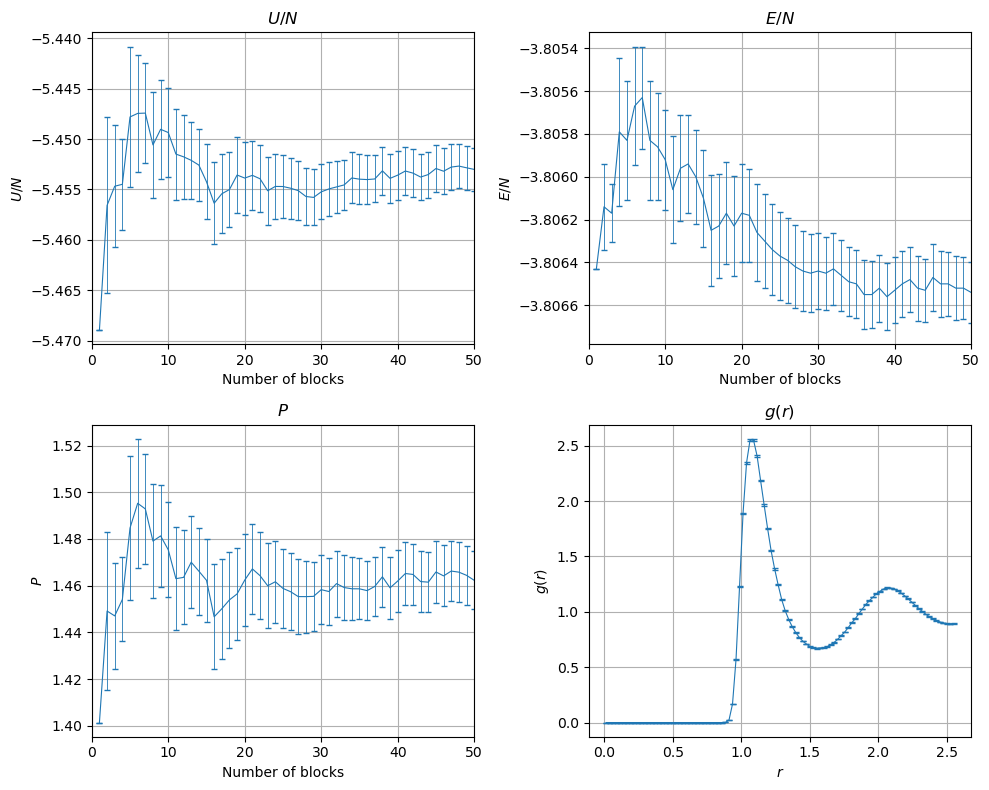

In [304]:
# Load progressive averages (liquid phase - MD)
Block,U_lMD,Uerr_lMD=np.loadtxt(base_path+"output_epot_liquidMD.dat",usecols=(0,2,3),unpack=True)
_,E_lMD,Eerr_lMD    =np.loadtxt(base_path+"output_etot_liquidMD.dat",usecols=(0,2,3), unpack=True)
_,P_lMD,Perr_lMD    =np.loadtxt(base_path+"output_pres_liquidMD.dat",usecols=(0,2,3), unpack=True)
# Load final g(r)
r_lMD,g_lMD,gerr_lMD  =np.loadtxt(base_path+"output_gfinal_liquidMD.dat",unpack=True)

fig,axs=plt.subplots(2,2,figsize=(10,8))
axs=axs.flatten()
data  =[U_lMD,E_lMD,P_lMD]
err   =[Uerr_lMD,Eerr_lMD,Perr_lMD]
titles=['$U/N$','$E/N$','$P$']
ylabs =[r'$U/N$',r'$E/N$',r'$P$']
for i in range(3):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
# g(r)
axs[3].errorbar(r_lMD,g_lMD,yerr=gerr_lMD,fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
axs[3].set_title('$g(r)$')
axs[3].set_xlabel(r'$r$')
axs[3].set_ylabel(r'$g(r)$')
axs[3].grid(True)

plt.tight_layout()
plt.show()

In [309]:
print(f"Potential energy per particle: {U_lMD[-1]:.4f}   ±{Uerr_lMD[-1]:.4f}  ----->  ( {U_lMD[-1]*eps/q*1000:.3f}  ±{Uerr_lMD[-1]*eps/q*1000:.3f}  ) meV")
print(f"Total energy per particle:     {E_lMD[-1]:.4f}   ±{Eerr_lMD[-1]:.4f}  ----->  ( {E_lMD[-1]*eps/q*1000:.4f} ±{Eerr_lMD[-1]*eps/q*1000:.4f} ) meV")
print(f"Pressure:                       {P_lMD[-1]:.3f}    ±{Perr_lMD[-1]:.3f}   ----->  ( {P_lMD[-1]*eps/(sigma)**3*10**(-5):.1f}    ±{Perr_lMD[-1]*eps/(sigma)**3*10**(-5):.1f}    ) bar")

Potential energy per particle: -5.4530   ±0.0021  ----->  ( -56.388  ±0.022  ) meV
Total energy per particle:     -3.8065   ±0.0001  ----->  ( -39.3627 ±0.0015 ) meV
Pressure:                       1.462    ±0.012   ----->  ( 616.4    ±5.3    ) bar


Confrontando quindi le due simulazioni per lo stato liquido si osserva che
- i valori di $U/N$ risultano pienamente compatibili statisticamente
- i valori di $E/N$ e $P$ sono molto simili, ma non statisticamente compatibili

Il motivo di ciò è molto probabilmente il fatto che la simulazione di dinamica molecolare è basata sulla modellizzazione del sistema secondo l'ensemble microcanonico, mentre la simulazione Monte Carlo lo fa mediante l'ensemble canonico. I due insiemi coincidono solo
- se sono alla stessa temperatura (verificato nell'_Esercizio 4.2_)
- se il sistema è lontano da un punto critico (condizione soddisfatta in questo caso)
- nel limite termodinamico

È possibile quindi che la finitezza del sistema (di $N$) sia la causa alla base di questa incompatibilità statistica. In ogni caso, la somiglianza dei risultati è comunque visibile, ed è un risultato incoraggiante nel mostrare come la meccanica statistica _sia corretta_: campionare il peso di Boltzmann (algoritmo di Metropolis, simulazioni Monte Carlo) corrisponde a generare configurazioni che sono le stesse che si ottengono risolvendo le equazioni del moto.

Infine, si mostra il confronto tra le distribuzioni $g(r)$ ottenute nei due casi:

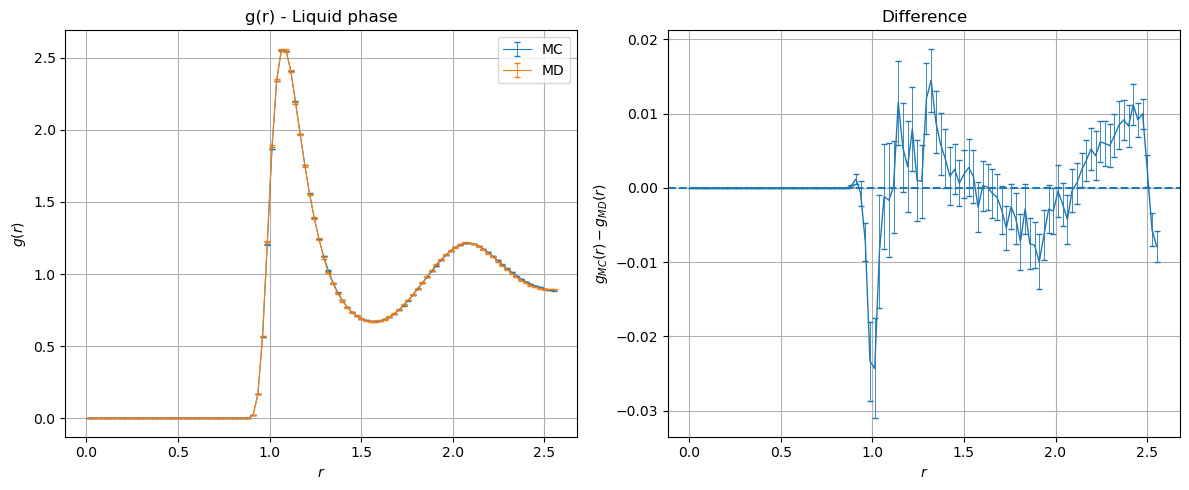

In [327]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
# g(r) MC vs MD ---
axs[0].errorbar(r_l,g_l,yerr=gerr_l,fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2,label='MC')
axs[0].errorbar(r_lMD,g_lMD,yerr=gerr_lMD,fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2,label='MD')
axs[0].set_xlabel(r'$r$')
axs[0].set_ylabel(r'$g(r)$')
axs[0].set_title('g(r) - Liquid phase')
axs[0].legend()
axs[0].grid(True)

# Difference
g_diff=g_l-g_lMD
gerr_diff=np.sqrt(gerr_l**2+gerr_lMD**2)
axs[1].errorbar(r_l,g_diff,yerr=gerr_diff,fmt='-',linewidth=1,elinewidth=0.6,capsize=2)
axs[1].axhline(0.0,linestyle='--')
axs[1].set_xlabel(r'$r$')
axs[1].set_ylabel(r'$g_{MC}(r)-g_{MD}(r)$')
axs[1].set_title('Difference')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Le due distribuzioni ottenute risultano pienamente compatibili: ogni punto in cui la loro differenza è stata calcolata è compatibile statisticamente con lo zero. Infatti, ogni punto dista dallo zero $\leq 3\sigma$, dove l'ampiezza della barra di errore $\sigma$ è data dalla radice della somma in quadratura delle incertezze sui valori di $g$ in tale punto.